In [1]:
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [457]:
import data_util
import models
import torch
import loss
import train
import pandas as pd
import numpy as np

In [214]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 160
proportional = True

is_gdro = True

hparams = {"groupdro_eta": 0.1}

In [96]:
subtype_df = pd.read_csv("data/lidc_spic_subgrouped_radiologist.csv")

# import data
df = pd.read_csv("data/LIDC_individual_radiologists.csv")
# preprocess data (normalization, remove anything that isn't in the chosen features)
df = data_util.preprocess_data(df)

In [97]:
sum(df["malignancy"] == 0) / len(df)

0.6133909287257019

In [98]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_radiologist.csv")

# create train/test dataframes
training_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "train"]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "test"]["noduleID"].values)]

# use noduleIDs as index, it makes things easier
subtype_df.index = subtype_df["noduleID"].values

# Test convergence of combinations of ERM and GDRO

In [458]:
N = 10
epochs = 40
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth"]
test_algorithms = ["ERM", "GDRO", "ReverseSmooth", "Adaptive"]

results = {algorithm: np.zeros(N * epochs * len(subtypes)) for algorithm in test_algorithms}
for algorithm in test_algorithms:

    print("Running test: " + algorithm)

    # create the training and testing dataloaders
    if algorithm == "ERM":
        train_dataloader = data_util.create_dataloader(training_df, batch_size)
    else:
        train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
    test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)

    for n in range(N):

        print(f"Trial {n + 1}/{N}")

        # create and train model
        model = models.NeuralNetwork(64, 32, 32, 2)
        model.to(device)

        if (algorithm == "ERM"):
            loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams)
        elif (algorithm == "GDRO"):
            loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), hparams)
        else:
            loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

        for epoch in range(epochs):
            if algorithm == "Sharp":
                loss_fn.t = epoch / epochs < 0.5  # sharp boundary
            elif algorithm == "Smooth":
                loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
            elif algorithm == "ReverseSmooth":
                loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
            elif algorithm == "Adaptive":
                acc = train.test(test_dataloader, model)[0]
                loss_fn.t = acc < 0.825  # use gdro when overall accuracy is above threshold
                
            train.train(train_dataloader, model, loss_fn, optimizer)
            sensitivities = train.test(test_dataloader, model)
            
            for i in range(len(subtypes)):
                results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

print("Test complete")

Running test: ERM
Trial 1/1
Running test: GDRO
Trial 1/1
Running test: ReverseSmooth
Trial 1/1
Running test: Adaptive
Trial 1/1
Test complete


In [459]:
trial_means = results_df.unstack().unstack().mean().unstack(level=0).unstack(level=0).stack()
trial_means

ERM      GDRO  ReverseSmooth  Adaptive
epoch subtype                                                            
0     Overall                 0.798742  0.803774       0.792453  0.815094
      Spiculated benign       0.916667  0.783333       0.866667  0.833333
      Spiculated malignant    0.827778  0.861111       0.850000  0.855556
      Unspiculated benign     0.858140  0.827907       0.827907  0.897674
      Unspiculated malignant  0.496000  0.648000       0.552000  0.464000
...                                ...       ...            ...       ...
39    Overall                 0.851572  0.808805       0.826415  0.774843
      Spiculated benign       0.900000  0.766667       0.833333  0.633333
      Spiculated malignant    0.888889  0.894444       0.888889  0.927778
      Unspiculated benign     0.867442  0.779070       0.825581  0.700000
      Unspiculated malignant  0.720000  0.808000       0.736000  0.880000

[200 rows x 4 columns]

In [460]:
worst_group = trial_means.unstack(level=0).min().unstack(level=0)
worst_group.index = pd.MultiIndex.from_product([["Worst"], worst_group.index], names=["subtype", "epoch"])
worst_concat = pd.concat([trial_means.unstack(level=0).stack(), worst_group])
worst_concat

ERM      GDRO  ReverseSmooth  Adaptive
subtype epoch                                             
Overall 0      0.798742  0.803774       0.792453  0.815094
        1      0.820126  0.797484       0.830189  0.791195
        2      0.811321  0.808805       0.825157  0.852830
        3      0.833962  0.825157       0.828931  0.836478
        4      0.831447  0.797484       0.800000  0.821384
...                 ...       ...            ...       ...
Worst   35     0.752000  0.716667       0.752000  0.723256
        36     0.712000  0.716667       0.760000  0.616667
        37     0.728000  0.683333       0.680000  0.650000
        38     0.584000  0.800000       0.720000  0.700000
        39     0.720000  0.766667       0.736000  0.633333

[240 rows x 4 columns]

In [ ]:
"""
Test parameters

input: 64 engineered features extracted from lidc max-slice images

model layer sizes = (64, 32, 32, 2)
groupdro_eta = 0.1
lr = 0.001
weight_decay = 0.005

batch_size = 40
proportional = True
epochs = 40
N = 120

"""

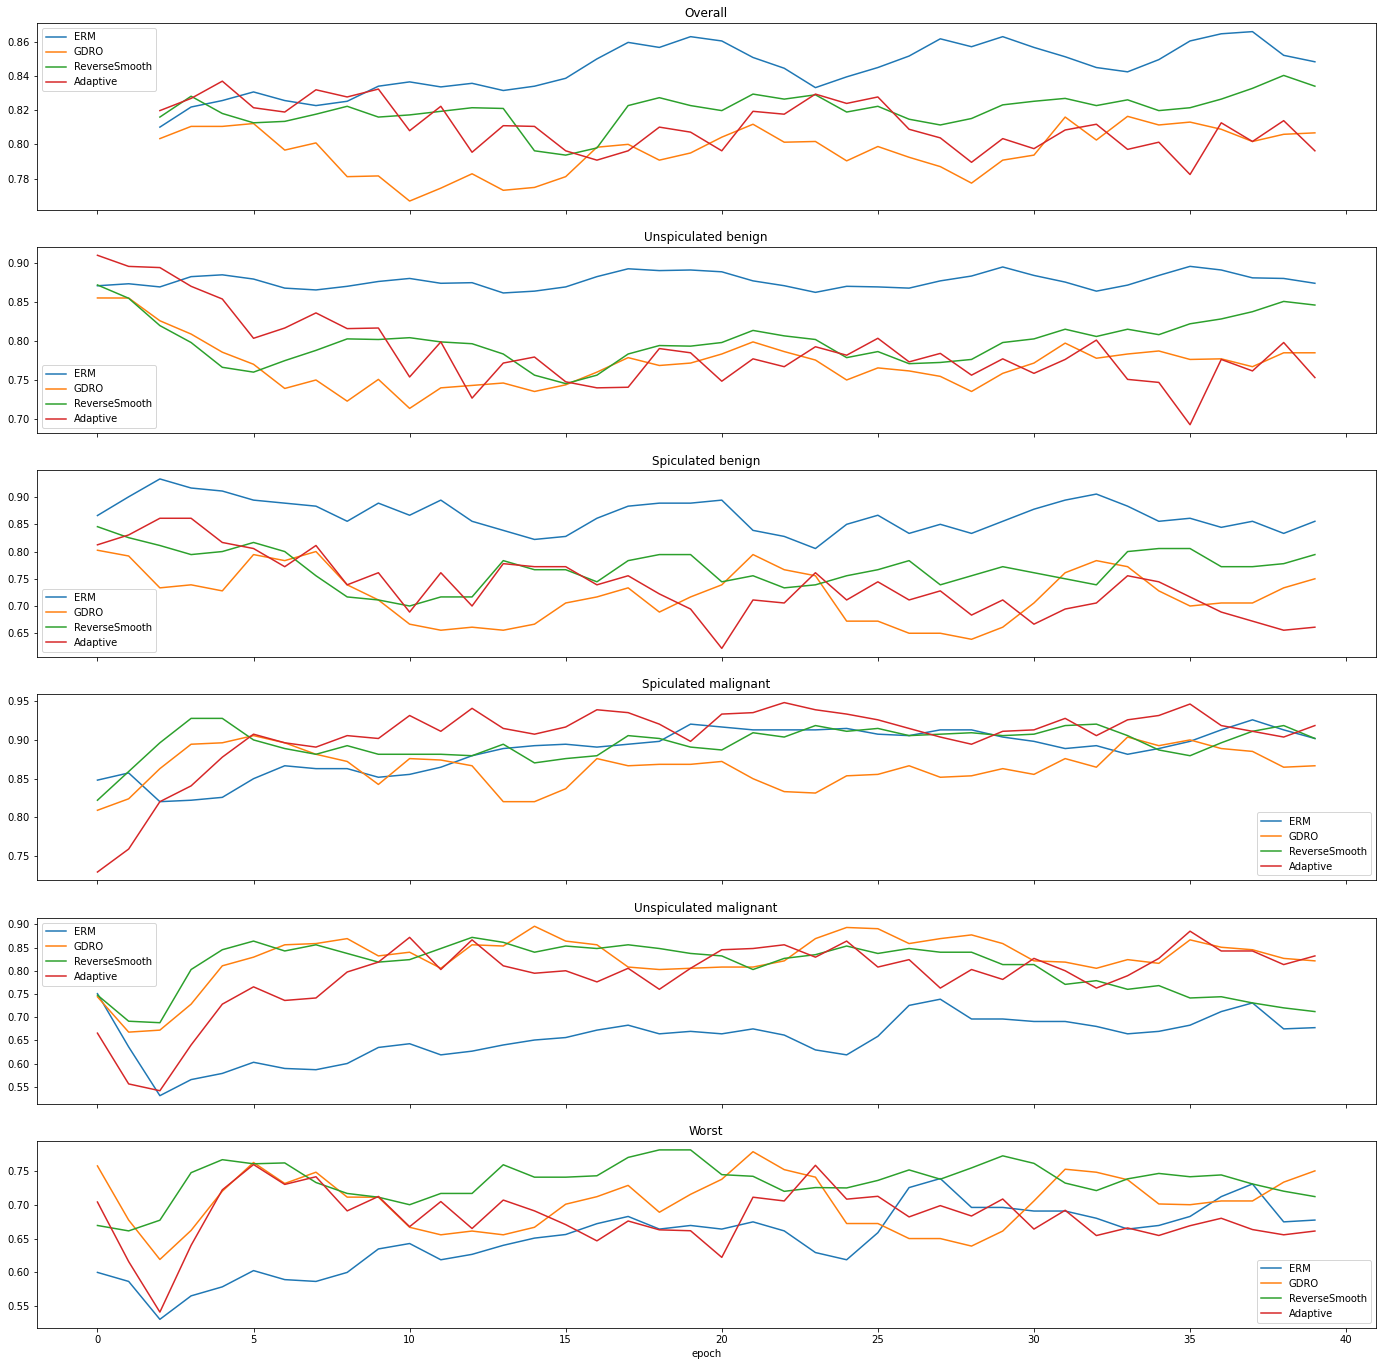

In [462]:
import matplotlib.pyplot as plt

rolling_window = 3

plots = [*subtypes, "Worst"]

f, a = plt.subplots(len(plots),1, sharex = True)
# plot subtypes sensitivity
for i in range(len(plots)):
    worst_concat.rolling(rolling_window).mean().xs(plots[i]).plot(kind='line',title=plots[i],ax=a[i],figsize=(24,24))
    
# plot worst-group sensitivity
#for a in test_algorithms:
    #worst_group.rolling(rolling_window).mean().plot(title="Worst group")

In [360]:
results_df.rolling(rolling_window).mean().loc[:, epochs - 1, :]

KeyError: 49

In [246]:
results_df

ERM      GDRO     Sharp    Smooth  \
subtype                epoch                                           
Overall                0      0.797799  0.802830  0.801572  0.804717   
                       1      0.815723  0.823899  0.818239  0.814465   
                       2      0.823270  0.822327  0.819811  0.816667   
                       3      0.831447  0.799686  0.816038  0.817610   
                       4      0.825786  0.805660  0.822013  0.831447   
...                                ...       ...       ...       ...   
Unspiculated malignant 45     0.656000  0.808000  0.784000  0.838000   
                       46     0.712000  0.810000  0.824000  0.812000   
                       47     0.660000  0.808000  0.826000  0.834000   
                       48     0.714000  0.812000  0.822000  0.812000   
                       49     0.666000  0.800000  0.800000  0.812000   

                              ReverseSmooth  
subtype                epoch                 
Overall                0           0.804717  
                       1           0.806604  
                       2           0.815409  
                       3           0.816981  
                       4           0.796226  
...                                     ...  
Unspiculated malignant 45          0.772000  
                       46          0.732000  
                       47          0.768000  
                       48          0.746000  
                       49          0.690000  

[250 rows x 5 columns]

In [88]:
from scipy.stats import ttest_ind
import statistics

# group_names = ["Overall", "GE MEDICAL SYSTEMS", "Unknown", "SIEMENS", "TOSHIBA", "Philips"]
group_names = ["Overall", "unmarked_benign", "marked_benign", "marked_malignant", "unmarked_malignant"]
# group_names = ["Overall", "0benign", "1benign", "0malignant", "1malignant"]
for i in range(5):
    print(group_names[i])
#     print(f"Mean ERM accuracy: {statistics.mean(data_clean[i]['ERM'])}")
#     print(f"Mean GDRO accuracy: {statistics.mean(data_clean[i]['GDRO'])}")
#     print(f"Mean Combined accuracy: {statistics.mean(data_clean[i]['Combined'])}")
    print(f"Mean Sharp accuracy: {statistics.mean(data_clean[i]['Sharp'])}")
    print(f"Mean Smooth accuracy: {statistics.mean(data_clean[i]['Smooth'])}")
    stat, p = ttest_ind(data_clean[i]["Sharp"], data_clean[i]["Smooth"])
    if p < 0.05:
        print(f"{'Sharp' if stat > 0 else 'Smooth'} higher accuracy (p = {p})")
    else:
        print(f"No statistically significant difference (p = {p})")
    print()
    

Overall


TypeError: 'numpy.float64' object is not iterable

In [ ]:
# old results with flawed malignancy labels + CNN subtypes
data_clean0